<a href="https://colab.research.google.com/github/nitinvarma02/projects/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Analyzing COVID-19 Testing, Hospitalization and Mortality Rates by State in USA

The COVID-19 pandemic has left an indelible mark on global health, economy, and society, underscoring the urgent need for vigilant monitoring and comprehension of key metrics such as testing rates and hospitalization rates. As the threat of pandemics or similar health crises persists, the ability to monitor these metrics becomes increasingly crucial for effective public health responses.

In this project, primary aim is to analyze COVID-19 testing data, hospitalization rates, and mortality rates across different states within the United States. By scrutinizing these metrics on a state-by-state basis, we seek to illuminate regional variations in testing accessibility, infection rates, and the strain on healthcare systems.


# Data
* https://healthdata.gov/dataset/COVID-19-Diagnostic-Laboratory-Testing-PCR-Testing/j8mb-icvb/about_data
* https://covid.cdc.gov/covid-data-tracker/#trends_cumulativehospitalizations_select_00
* https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-Distribution-of-Deaths/pj7m-y5uh/about_data
* https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/workspace/file?filename=3_cases_and_deaths_by_state_timeseries.csv
* https://eric.clst.org/tech/usgeojson/


# Imports

In [ ]:
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
diagnostics = pd.read_csv('diagnostics.csv') # loading data into colb
#diagnostics = diagnostics.copy()

#Data cleaning
diagnostics.drop(['state','state_fips', 'fema_region'], axis=1) # dropping unnecessary columns
diagnostics.rename(columns={'state_name': 'State'}, inplace= True) # renaming the column to facilitate merging
diagnostics['date'] = pd.to_datetime(diagnostics['date']).dt.year #datatype conversion
diagnostics['new_results_reported'] = diagnostics['new_results_reported'].astype(int) # datatype conversion
diagnostics.rename(columns={'new_results_reported': 'positive_results'}, inplace = True)
diagnostics = diagnostics[diagnostics['date'].isin([2020, 2021, 2022])] # including only 2020 & 2021 data

In [ ]:
diagnostic = diagnostics[diagnostics['overall_outcome'] == 'Positive']
# Group by State and calculate the sum of total_results_reported column for positive outcomes
diagnostics_positive = diagnostic.groupby('State').agg({'positive_results': 'sum'}).reset_index()

# COVID-19 diagnostics - positive results

In [ ]:
diagnostics_positive.head()


,State,positive_results
0,Alabama,1248698
1,Alaska,389547
2,Arizona,2188482
3,Arkansas,571009
4,California,11476997


In [ ]:
# Data on COVID-19 hospitalizations
zip_file = 'States.zip'

# Extract the zip file contents
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

# Initialize an empty list to store the final dataframes for each state
final_data = []

# Loop through each CSV file in the extracted folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    for csv_file_name in zip_ref.namelist():
        with zip_ref.open(csv_file_name) as file:
            hospitalizations = pd.read_csv(file, skiprows=[0, 1]) #skip forst 2 rows
            hospitalizations = hospitalizations.dropna()
            hospitalizations = hospitalizations.rename(columns={'Geography':'State','Cumulative COVID-19 Hospitalizations':'total_hospitalizations'})  # Rename columns
            hospitalizations['State'] = hospitalizations['State'].replace({'Virgin Islands': 'U.S. Virgin Islands'})  # Replace values
            hospitalizations['Date'] = pd.to_datetime(hospitalizations['Date']).dt.year  # Convert date to year
            hospitalizations['total_hospitalizations'] = hospitalizations['total_hospitalizations'].astype(int)  # Convert datatype

            # Get the last updated date
            last_date_2020 = hospitalizations[hospitalizations['Date'] == 2020]['Date'].max()
            last_date_2021 = hospitalizations[hospitalizations['Date'] == 2021]['Date'].max()
            last_date_2022 = hospitalizations[hospitalizations['Date'] == 2022]['Date'].max()

            # Filter the DataFrame to include only the rows with the last date of 2020, 2021, and 2022
            hospitalizations = hospitalizations[hospitalizations['Date'].isin([last_date_2020, last_date_2021, last_date_2022])]

            # Sum cumulative COVID-19 hospitalizations for 2020, 2021, and 2022
            df = hospitalizations.groupby('State').agg({'total_hospitalizations':'sum'}).reset_index()

            # Append the final dataframe to the list
            final_data.append(df)

# Merge dataframes for all states
hospitalization_df = pd.concat(final_data, ignore_index=True)


# Hospitalization count

In [ ]:
hospitalization_df.head()

,State,total_hospitalizations
0,Alabama,8144621
1,Alaska,542006
2,American Samoa,7129
3,Arizona,10044458
4,Arkansas,4501542


In [ ]:
#merging 2 tables
merged_p_h = pd.merge(diagnostics_positive, hospitalization_df, on= 'State', how= 'inner')
merged_p_h.head()

,State,positive_results,total_hospitalizations
0,Alabama,1248698,8144621
1,Alaska,389547,542006
2,Arizona,2188482,10044458
3,Arkansas,571009,4501542
4,California,11476997,36760061


In [ ]:

# Read the data
death_race = pd.read_csv('https://data.cdc.gov/api/views/pj7m-y5uh/rows.csv?access')

# Drop unnecessary columns
death_race.drop(columns=['Month', 'Footnote', 'Data as of', 'Start Date', 'End Date'], inplace=True)

# Filter data for 'Count of COVID-19 deaths' indicator and 'By Year' group
death_race = death_race[(death_race['Indicator'] == 'Count of COVID-19 deaths') &
                        (death_race['Group'] == 'By Year')]

# Filter for rows with 'Year' column containing '2020', '2021', or '2022'
death_race = death_race[death_race['Year'].isin(['2020', '2021', '2022'])]

# Select only the required columns
death_race_ethnicity = death_race[['State', 'Non-Hispanic White',
                                   'Non-Hispanic Black or African American',
                                   'Non-Hispanic American Indian or Alaska Native',
                                   'Non-Hispanic Asian',
                                   'Non-Hispanic Native Hawaiian or Other Pacific Islander',
                                   'Non Hispanic more than one race', 'Hispanic or Latino']]

# Sum deaths for each state
death_race_ethnicity = death_race_ethnicity.groupby('State').sum().reset_index()


# Death count among different Race/Ethnicity

In [ ]:
death_race_ethnicity.head()

,State,Non-Hispanic White,Non-Hispanic Black or African American,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Non Hispanic more than one race,Hispanic or Latino
0,Alabama,14533.0,5550.0,34.0,99.0,0.0,17.0,381.0
1,Alaska,759.0,17.0,370.0,91.0,55.0,28.0,39.0
2,Arizona,16731.0,1020.0,2332.0,524.0,70.0,267.0,8085.0
3,Arkansas,9765.0,1683.0,85.0,71.0,69.0,47.0,411.0
4,California,38678.0,7199.0,646.0,11856.0,668.0,811.0,44146.0


In [ ]:
death_total = pd.read_csv('death.csv')

death_total= death_total.dropna().copy()
# renaming state column to State for merging
death_total.rename(columns={'state': 'State','cumulative_deaths':'total_covid_deaths'}, inplace=True)

#changing datatype to datatime
death_total['date'] = pd.to_datetime(death_total['date'])
#converting population to int
death_total['total_population'] = death_total['total_population'].astype(int)

# 2020 and 2021
last_date_20 = death_total[death_total['date'].dt.year == 2020]['date'].max()
last_date_21 = death_total[death_total['date'].dt.year == 2021]['date'].max()
last_date_22 = death_total[death_total['date'].dt.year == 2022]['date'].max()

# last date of 2020 and 2021
death_total = death_total[death_total['date'].isin([last_date_20, last_date_21,last_date_22])]

# only including columns required
death_total = death_total[['State','total_population','total_covid_deaths']]

death_total = death_total.groupby('State').sum().reset_index()

# Overall covid deaths

In [ ]:
death_total.head()

,State,total_population,total_covid_deaths
0,Alabama,14663613,42019
1,Alaska,2212314,2639
2,Arizona,21514938,65275
3,Arkansas,9041475,25519
4,California,118671135,200868


In [ ]:
death_RE_total = pd.merge(death_total, death_race_ethnicity , on='State', how= 'inner')
death_RE_total.head()

,State,total_population,total_covid_deaths,Non-Hispanic White,Non-Hispanic Black or African American,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Non Hispanic more than one race,Hispanic or Latino
0,Alabama,14663613,42019,14533.0,5550.0,34.0,99.0,0.0,17.0,381.0
1,Alaska,2212314,2639,759.0,17.0,370.0,91.0,55.0,28.0,39.0
2,Arizona,21514938,65275,16731.0,1020.0,2332.0,524.0,70.0,267.0,8085.0
3,Arkansas,9041475,25519,9765.0,1683.0,85.0,71.0,69.0,47.0,411.0
4,California,118671135,200868,38678.0,7199.0,646.0,11856.0,668.0,811.0,44146.0


In [ ]:
final_df= pd.merge(merged_p_h, death_RE_total, on= 'State', how='inner')
final_df.head()

,State,positive_results,total_hospitalizations,total_population,total_covid_deaths,Non-Hispanic White,Non-Hispanic Black or African American,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Non Hispanic more than one race,Hispanic or Latino
0,Alabama,1248698,8144621,14663613,42019,14533.0,5550.0,34.0,99.0,0.0,17.0,381.0
1,Alaska,389547,542006,2212314,2639,759.0,17.0,370.0,91.0,55.0,28.0,39.0
2,Arizona,2188482,10044458,21514938,65275,16731.0,1020.0,2332.0,524.0,70.0,267.0,8085.0
3,Arkansas,571009,4501542,9041475,25519,9765.0,1683.0,85.0,71.0,69.0,47.0,411.0
4,California,11476997,36760061,118671135,200868,38678.0,7199.0,646.0,11856.0,668.0,811.0,44146.0


# Bar chart

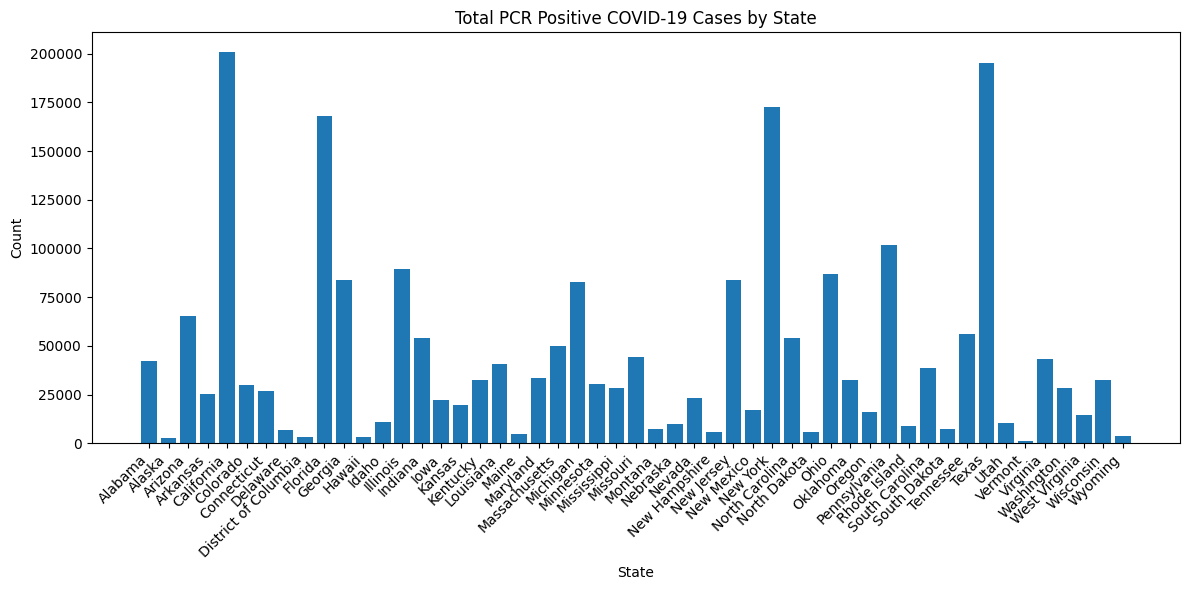

In [ ]:
states = final_df['State']
positive_results = final_df['positive_results']

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(states, positive_results)
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Total PCR Positive COVID-19 Cases by State')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

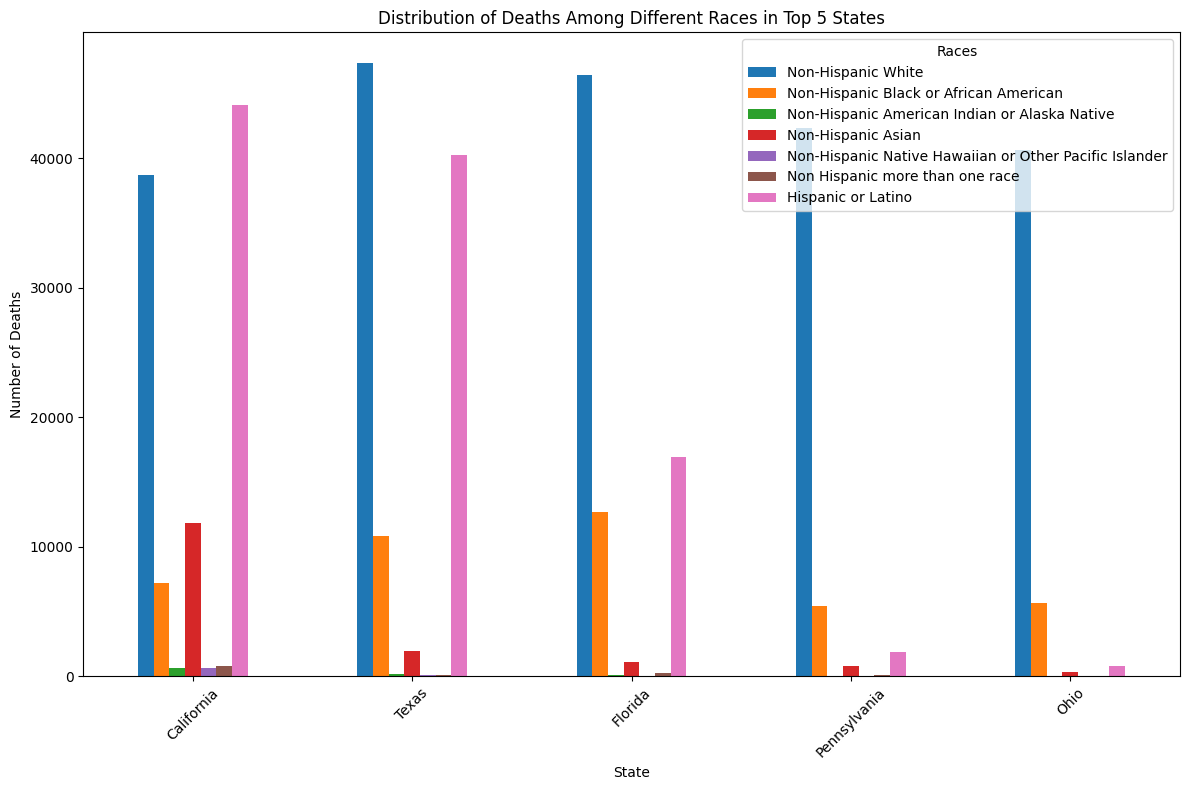

In [ ]:
# 1. Calculate the total death counts for each ethnicity/race in each state
stats_per_state = final_df.groupby('State').agg({
    'Non-Hispanic White': 'sum',
    'Non-Hispanic Black or African American': 'sum',
    'Non-Hispanic American Indian or Alaska Native': 'sum',
    'Non-Hispanic Asian': 'sum',
    'Non-Hispanic Native Hawaiian or Other Pacific Islander': 'sum',
    'Non Hispanic more than one race': 'sum',
    'Hispanic or Latino': 'sum'
})

# 2. Select the top 5 states based on the total death counts
top_5_states = stats_per_state.sum(axis=1).nlargest(5).index

# 3. Plot a bar graph showing the distribution of deaths among different ethnicities/races for each of the top 5 states
top_5_stats = stats_per_state.loc[top_5_states]
top_5_stats.plot(kind='bar', figsize=(12, 8))
plt.title('Distribution of Deaths Among Different Races in Top 5 States')
plt.xlabel('State')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)
plt.legend(title='Races')
plt.tight_layout()
plt.show()


In [ ]:
top_5_states

Index(['California', 'Texas', 'Florida', 'Pennsylvania', 'Ohio'], dtype='object', name='State')

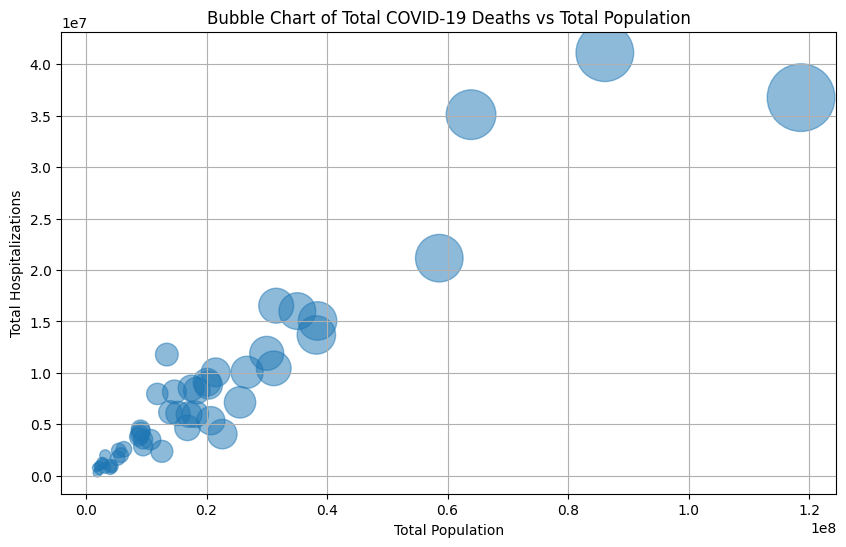

In [ ]:
# Plot the Bubble Chart
plt.figure(figsize=(10, 6))
plt.scatter(final_df['total_population'], final_df['total_hospitalizations'], s=final_df['total_population'] / 50000, alpha=0.5)
plt.xlabel('Total Population')
plt.ylabel('Total Hospitalizations')
plt.title('Bubble Chart of Total COVID-19 Deaths vs Total Population')
plt.grid(True)
plt.show()


# Choropleth Map

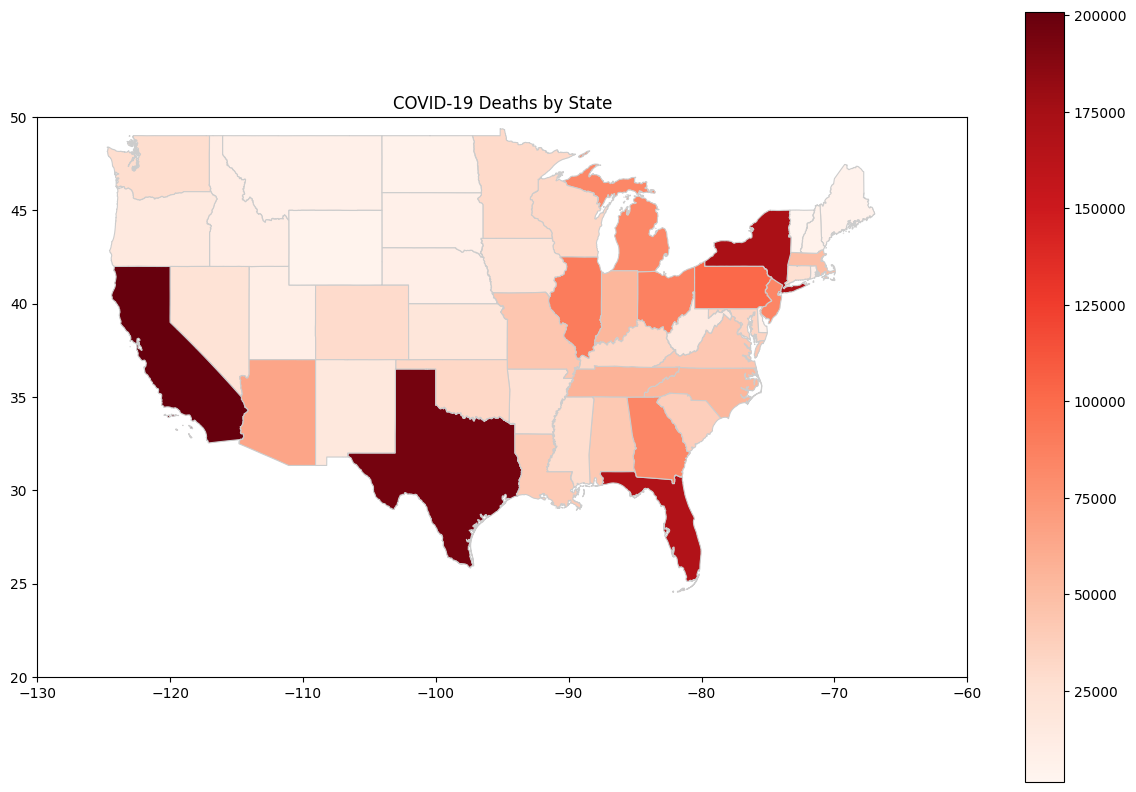

In [ ]:
# Load state boundaries data
state_boundaries = gpd.read_file('geojson_states.json')

# Rename the column 'NAME' to 'State' to facilitate merge
state_boundaries.rename(columns={'NAME': 'State'}, inplace=True)

# Merge final_df with state boundaries data
merged_data = state_boundaries.merge(final_df, on='State', how='left')

# Plot Choropleth Map
fig, ax = plt.subplots(figsize=(15, 10))
merged_data.plot(column='total_covid_deaths', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_xlim([-130, -60])
ax.set_ylim([20, 50])

plt.title('COVID-19 Deaths by State')
plt.show()


# Conclusion
The analysis of COVID-19 metrics across states underscores the widespread impact of the pandemic. High numbers of positive cases in populous states such as California, Texas, and Florida indicate significant viral transmission. Correspondingly, these states also exhibit elevated rates of hospitalizations, reflecting the strain on healthcare systems due to the large infected populations. Moreover, the total COVID-19 deaths, particularly in these densely populated regions, are substantial, emphasizing the severity of the pandemic's impact. Additionally, an examination of ethnicity distribution reveals disparities in COVID-19 outcomes. While Non-Hispanic White populations generally show higher mortality rates across most states, Non-Hispanic Black or African American populations also experience significant mortality. Furthermore, Hispanic or Latino communities in states like California and Texas face notable mortality rates, highlighting inequalities in healthcare access and outcomes. The bubble chart analysis reinforces the correlation between total population and COVID-19 deaths, indicating that densely populated areas are particularly vulnerable to the spread of the virus and its associated consequences.